# Getting started

In this notebook, we get familiar with both Bilby (LALSuite) and ripple. We check how to generate waveforms with both packages and how they compare to each other. We also figure out how the LAL code (written in C) has been translated to Python (JAX) to get an idea on how to extend it towards the NRTidal waveform.

In [2]:
import numpy as np
import matplotlib.pyplot as plt

## IMRPhenomD in Bilby

We are using **Bilby**: 

- Documentation can be found [here](https://lscsoft.docs.ligo.org/bilby/). 
- Examples of code can be found [here](https://lscsoft.docs.ligo.org/bilby/examples.html). 
- The source code can be found [here](https://git.ligo.org/lscsoft/bilby)

The source code for the IMRPhenomD waveform model can be found [here](https://docs.ligo.org/lscsoft/lalsuite/lalsimulation/_l_a_l_sim_i_m_r_phenom_d___n_r_tidal_8c_source.html). 

In [3]:
import bilby
import lal

**TODO** How do ra, dec and theta_jn match with polarization angle in ripple? Check out lalmatch code in ripple?

In [4]:
injection_parameters = dict(
    mass_1 = 20., 
    mass_2 = 19., 
    
    chi_1 = 0.5,  
    chi_2 = -0.5, 
    ra = 0.0, 
    dec = 0.2, 
    luminosity_distance = 440., 
    theta_jn = 0., 
    
    psi = 0., 
    geocent_time = 0., 
    phase = 0., 
)

In [5]:
minimum_frequency = 24. 
sampling_frequency = 2*512.
duration = 8. 
reference_frequency = minimum_frequency
waveform_approximant = 'IMRPhenomD'

In [6]:
waveform_arguments = dict(minimum_frequency = minimum_frequency, reference_frequency = reference_frequency, waveform_approximant = waveform_approximant)
waveform_generator = bilby.gw.WaveformGenerator(duration = duration, sampling_frequency = sampling_frequency, 
                                                frequency_domain_source_model = bilby.gw.source.lal_binary_black_hole,
        parameter_conversion=bilby.gw.conversion.convert_to_lal_binary_black_hole_parameters,
        waveform_arguments=waveform_arguments)

12:00 bilby INFO    : Waveform generator initiated with
  frequency_domain_source_model: bilby.gw.source.lal_binary_black_hole
  time_domain_source_model: None
  parameter_conversion: bilby.gw.conversion.convert_to_lal_binary_black_hole_parameters


In [7]:
polas_bilby = waveform_generator.frequency_domain_strain(injection_parameters)

hp_bilby, hc_bilby = polas_bilby['plus'], polas_bilby['cross']

/Users/Woute029/anaconda3/envs/ripple/lib/python3.11/site-packages/matplotlib/cbook/__init__.py:1340: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


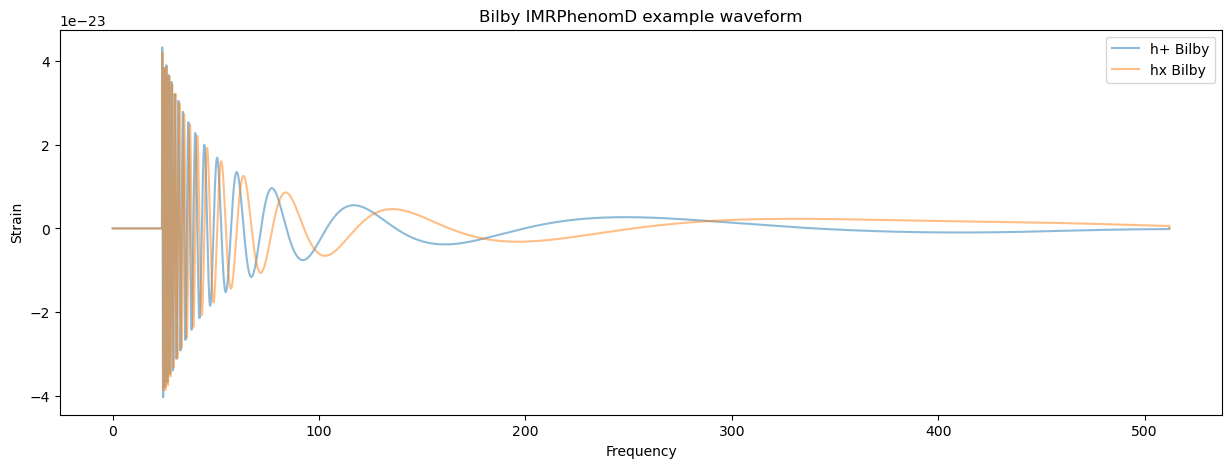

In [19]:
plt.figure(figsize=(15, 5))
plt.plot(waveform_generator.frequency_array, hp_bilby, label = "h+ Bilby", alpha = 0.5)
plt.plot(waveform_generator.frequency_array, hc_bilby, label = "hx Bilby", alpha = 0.5)

plt.legend()
plt.title("Bilby IMRPhenomD example waveform")
plt.xlabel("Frequency")
plt.ylabel("Strain")
plt.show()

## IMRPhenomD in ripple

The IMRPhenomD waveform has already been implemented into ripple in its initial release.

- The source code to generate the waveform can be found [here](https://github.com/tedwards2412/ripple/blob/main/src/ripple/waveforms/IMRPhenomD.py#L554)
- The example code below is provided on ripple's Github, see [here](https://github.com/tedwards2412/ripple/blob/bfe9b772d862fe2e9a8e796888b65c0a56c50b6f/notebooks/Generating_waveforms.ipynb)

In [9]:
import jax.numpy as jnp

from ripple.waveforms import IMRPhenomD
import matplotlib.pyplot as plt
from ripple import ms_to_Mc_eta
from jax import grad, vmap
from functools import partial

In [10]:
# Get a frequency domain waveform
# source parameters

m1_msun = 20.0 # In solar masses
m2_msun = 19.0
chi1 = 0.5 # Dimensionless spin
chi2 = -0.5
tc = 0.0 # Time of coalescence in seconds
phic = 0.0 # Time of coalescence
dist_mpc = 440 # Distance to source in Mpc
inclination = 0.0 # Inclination Angle
polarization_angle = 0.2 # Polarization angle

# Convert component masses to chirp mass and eta
Mc, eta = ms_to_Mc_eta(jnp.array([m1_msun, m2_msun]))

# These are the parametrs that go into the waveform generator
# Note that JAX does not give index errors, so if you pass in the
# the wrong array it will behave strangely
theta_ripple = jnp.array([Mc, eta, chi1, chi2, dist_mpc, tc, phic, inclination, polarization_angle])

# Now we need to generate the frequency grid
f_l = 24
f_u = 512
del_f = 0.01
fs = jnp.arange(f_l, f_u, del_f)

# We also need to give a reference frequency - here, this will be the lower frequency
f_ref = f_l

# And finally lets generate the waveform!
hp_ripple, hc_ripple = IMRPhenomD.gen_IMRPhenomD_hphc(fs, theta_ripple, f_ref)

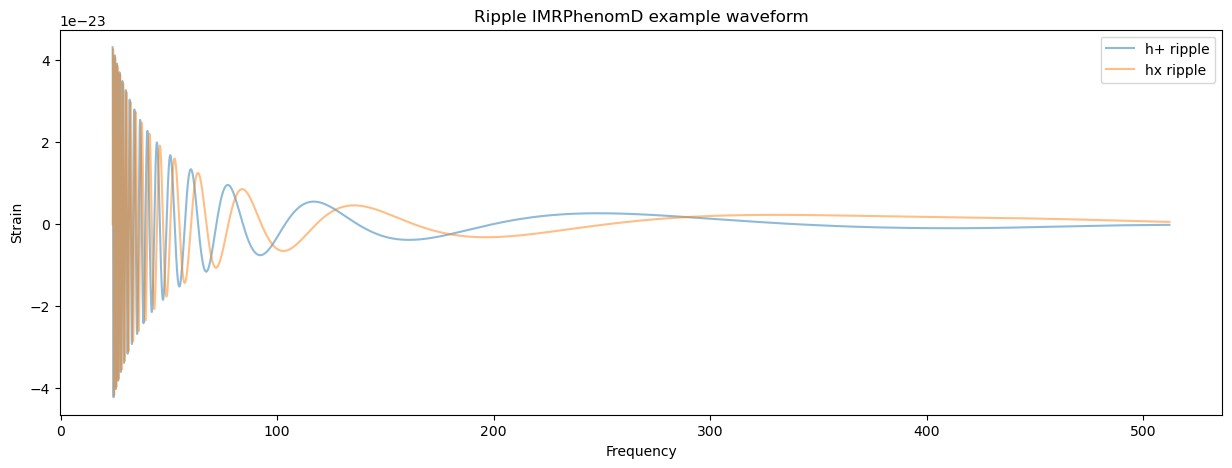

In [11]:
# Now we can plot it
plt.figure(figsize=(15, 5))

plt.plot(fs, hp_ripple.real, label="h+ ripple", alpha=0.5)
plt.plot(fs, hc_ripple.real, label="hx ripple", alpha=0.5)

plt.legend()
plt.title("Ripple IMRPhenomD example waveform")
plt.xlabel("Frequency")
plt.ylabel("Strain")
plt.show()

## Comparison

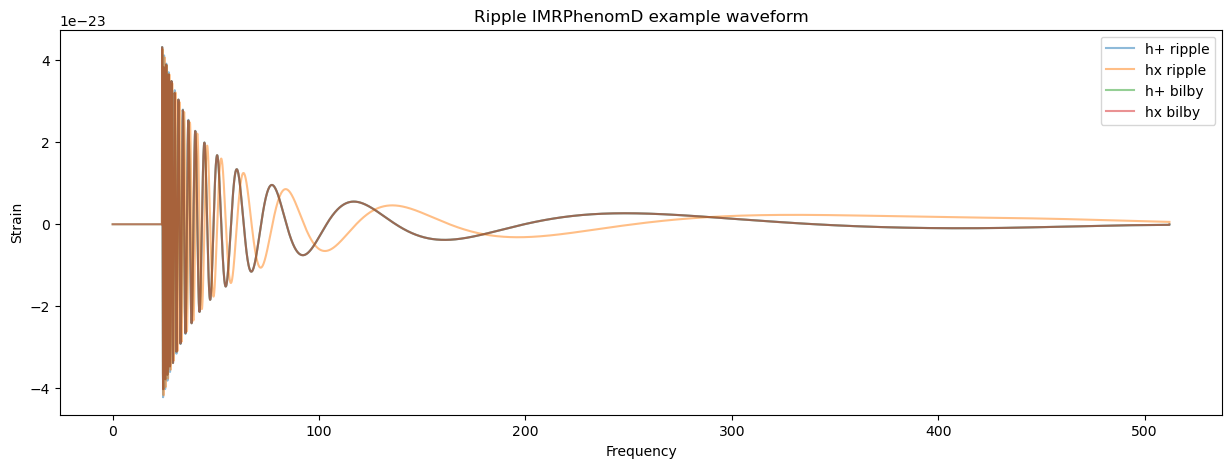

In [12]:
# Now we can plot it
plt.figure(figsize=(15, 5))

plt.plot(fs, hp_ripple.real, label="h+ ripple", alpha=0.5)
plt.plot(fs, hc_ripple.real, label="hx ripple", alpha=0.5)

plt.plot(waveform_generator.frequency_array, hp_bilby, label="h+ bilby", alpha=0.5)
plt.plot(waveform_generator.frequency_array, hp_bilby, label="hx bilby", alpha=0.5)

plt.legend()
plt.title("Ripple IMRPhenomD example waveform")
plt.xlabel("Frequency")
plt.ylabel("Strain")
plt.show()

In [13]:
fs

Array([ 24.     ,  24.01   ,  24.02   , ..., 511.98117, 511.99118,
       512.00116], dtype=float32)

In [14]:
waveform_generator.frequency_array

array([0.00000e+00, 1.25000e-01, 2.50000e-01, ..., 5.11750e+02,
       5.11875e+02, 5.12000e+02])

In [ ]:
# Now we can plot it
plt.figure(figsize=(15, 5))

plt.plot(fs, hp_ripple.real, label="h+ ripple", alpha=0.5)
plt.plot(fs, hc_ripple.real, label="hx ripple", alpha=0.5)

plt.plot(waveform_generator.frequency_array, hp_bilby, label="h+ bilby", alpha=0.5)
plt.plot(waveform_generator.frequency_array, hp_bilby, label="hx bilby", alpha=0.5)

plt.legend()
plt.title("Ripple IMRPhenomD example waveform")
plt.xlabel("Frequency")
plt.ylabel("Strain")
plt.show()

## Going beyond - BNS

Have to figure out what to do for NRTidal. Possible ways to start:
- Check [this reference notebook](https://git.ligo.org/lscsoft/bilby/-/blob/master/examples/gw_examples/injection_examples/binary_neutron_star_example.py), this is Bilby generating a waveform with NRTidal